In [117]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns
from math import sqrt

# Loads 4 different variables
grid = netCDF4.Dataset('/dat1/haoqik/data/easegrid_xy.nc','r')
x = np.array(grid.variables["x_grid"])
y = np.array(grid.variables["y_grid"])

ocean1 = np.load("/dat1/haoqik/data/ocean_velocity_2003-2014_uv.npz")
ocean_vel_u_1 = ocean1["u"]
ocean_vel_v_1 = ocean1["v"]
ocean_time_1 = ocean1["time"]

ocean2 = np.load("/dat1/haoqik/data/ocean_velocity_u_v_2011-2020.npz")
ocean_vel_u_2 = ocean2["u"]
ocean_vel_v_2 = ocean2["v"]
ocean_time_2 = ocean2["time"]

wind = np.load("/dat1/haoqik/data/seawind_1971-2021_u_v.npz")
seawind_u = wind["u"]
seawind_v = wind["v"]
seawind_time = wind["time"]

sea_ice = np.load("/dat1/haoqik/data/sea_ice_motion_1978.11-2021.12_u_v.npz")
sea_ice_u = sea_ice["u"]
sea_ice_v = sea_ice["v"]
sea_ice_time = sea_ice["time"]

ice_con_data = np.load("/dat1/haoqik/data/ice_concentration_1978.11-2021.12_ice.npz")
ice_con = ice_con_data["ice"]
ice_con_time = ice_con_data['time']

# put ice_con = 1 in the middle of the north pole
indices = np.argwhere(ice_con[0]<0.85)
indices = indices[(indices[:,0] <=207) &(indices[:,0] >=156) &(indices[:,1] <=207)& (indices[:,1] >=156)]
X = np.transpose(indices)[0,:]

Y = np.transpose(indices)[1,:]

ice_con[:, X, Y] = 1
ice_con[ice_con < 0.05] = np.nan

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [118]:
# select only the left top parts in the graph by setting index [:,180:360,0:180]
wu = np.empty((612, 361, 361))
wu[:] = np.nan
wu[:,180:360,0:180] = wind['u'][:,180:360,0:180]

wv = np.empty((612, 361, 361))
wv[:] = np.nan
wv[:,180:360,0:180] = wind['v'][:,180:360,0:180]

ou = np.empty((361, 361, 144))
ou[:] = np.nan
ou[180:360,0:180,:] = ocean1['u'][180:360,0:180,:]

ov = np.empty((361, 361, 144))
ov[:] = np.nan
ov[180:360,0:180,:] = ocean1['v'][180:360,0:180,:]

su = np.empty((528, 361, 361))
su[:] = np.nan
su[:,180:360,0:180] = sea_ice['u'][:,180:360,0:180]

sv = np.empty((528, 361, 361))
sv[:] = np.nan
sv[:,180:360,0:180] = sea_ice['v'][:,180:360,0:180]

ce = np.empty((518, 361, 361))
ce[:] = np.nan
ce[:,180:360,0:180] = ice_con[:,180:360,0:180]

In [119]:
def plot(x, y, ocean_u, ocean_v, N = 4):
    """
    This function takes x, y, ocean_u, and ocean_v
    that are all in ease grid form, and returns ocean
    plot
    """
    extent = 2500000
    #plt.contour(x, y, mask_land)
    _x = x[::N]
    _y = y[::N]

    _U2 = ocean_u[::N, ::N]
    _V2 = ocean_v[::N, ::N]

    fig = plt.figure(figsize=[10, 10])
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='gray', facecolor=sns.xkcd_rgb['tan'])
    ax.set_extent((-extent,extent,-extent,extent), crs=ccrs.NorthPolarStereo())

    ax.quiver(_x, _y, _U2, _V2, scale=1)
    ax.title.set_text('Ocean Velocity')

    plt.show()


def start_end_time(variables_time, train_start_time, train_end_time, test_start_time, test_end_time):
    """
    This function takes a variable time axis along with train and test data start and time,
    return the corresponding index where the time locate in the variable time axis.
    """
    train_start = int(np.argwhere(variables_time == train_start_time))
    train_end = int(np.argwhere(variables_time == train_end_time))+1
    test_start = int(np.argwhere(variables_time == test_start_time))
    test_end = int(np.argwhere(variables_time == test_end_time))+1


    return train_start, train_end, test_start, test_end


def preprocess_X_y(train_start_time, train_end_time, test_start_time, test_end_time):
    """
    This function takes train start, train end, test start and test end time, and
    returns the X_train, X_test, y_train, y_test, the index of non nan value
    in test data where input 5 variables are not nan values, X_test to make plots,
    and original y_test with nan values.
    """
    # load the time var
    start_wind, end_wind, start_wind_test, end_wind_test = start_end_time(seawind_time, train_start_time, train_end_time, test_start_time, test_end_time)
    start_sea_ice, end_sea_ice, start_sea_ice_test, end_sea_ice_test = start_end_time(sea_ice_time, train_start_time, train_end_time, test_start_time, test_end_time)
    start_ocean, end_ocean, start_ocean_test, end_ocean_test = start_end_time(ocean_time_1, train_start_time, train_end_time, test_start_time, test_end_time)
    start_ice_con, end_ice_con, start_ice_con_test, end_ice_con_test = start_end_time(ice_con_time, train_start_time, train_end_time, test_start_time, test_end_time)
    
    # X_train flatten
    d1_wind_v = wv[start_wind:end_wind,:,:].flatten()
    d1_wind_u = wu[start_wind:end_wind,:,:].flatten()
    d1_sea_ice_u = su[start_sea_ice:end_sea_ice,:,:].flatten()
    d1_sea_ice_v = sv[start_sea_ice:end_sea_ice,:,:].flatten()
    d1_ice_con = ce[start_ice_con:end_ice_con,:,:].flatten()
    
    # X_test flatten
    test_wind_v = wv[start_wind_test:end_wind_test,:,:].flatten()
    test_wind_u = wu[start_wind_test:end_wind_test,:,:].flatten()
    test_sea_ice_u = su[start_sea_ice_test:end_sea_ice_test,:,:].flatten()
    test_sea_ice_v = sv[start_sea_ice_test:end_sea_ice_test,:,:].flatten()
    test_ice_con = ce[start_ice_con_test:end_ice_con_test,:,:].flatten()
    
    # y_train flatten
    d1_ocean_v = ov[:,:,start_ocean:end_ocean].flatten()
    d1_ocean_u = ou[:,:,start_ocean:end_ocean].flatten()

    # y_test flatten
    test_ocean_v = ov[:,:,start_ocean_test:end_ocean_test].flatten()
    test_ocean_u = ou[:,:,start_ocean_test:end_ocean_test].flatten()
    
    # get the non na values' indices and original y_test with both u and v
    use_index_train = np.argwhere((~np.isnan(d1_wind_v))&(~np.isnan(d1_wind_u))&(~np.isnan(d1_sea_ice_u))&(~np.isnan(d1_sea_ice_v))&(~np.isnan(d1_ice_con))&(~np.isnan(d1_ocean_v))&(~np.isnan(d1_ocean_u)))
    use_index_x_test = np.argwhere((~np.isnan(test_wind_v))&(~np.isnan(test_wind_u))&(~np.isnan(test_sea_ice_u))&(~np.isnan(test_sea_ice_v))&(~np.isnan(test_ice_con)))
    use_index_y_test = np.argwhere((~np.isnan(test_wind_v))&(~np.isnan(test_wind_u))&(~np.isnan(test_sea_ice_u))&(~np.isnan(test_sea_ice_v))&(~np.isnan(test_ice_con))&(~np.isnan(test_ocean_v))&(~np.isnan(test_ocean_u)))
    y_original = np.vstack((test_ocean_v, test_ocean_u)).T
    
    # X_train with no nan values
    numerical_wind_v_train = d1_wind_v[use_index_train[:]]
    numerical_wind_u_train = d1_wind_u[use_index_train[:]]
    numerical_sea_ice_u_train = d1_sea_ice_u[use_index_train[:]]
    numerical_sea_ice_v_train = d1_sea_ice_v[use_index_train[:]]
    numerical_ice_con_train = d1_ice_con[use_index_train[:]]

    # X_test with no nan values
    numerical_wind_v_test = test_wind_v[use_index_y_test[:]]
    numerical_wind_u_test = test_wind_u[use_index_y_test[:]]
    numerical_sea_ice_u_test = test_sea_ice_u[use_index_y_test[:]]
    numerical_sea_ice_v_test = test_sea_ice_v[use_index_y_test[:]]
    numerical_ice_con_test = test_ice_con[use_index_y_test[:]]

    # y_train with no nan values
    numerical_ocean_v = d1_ocean_v[use_index_train[:]]
    numerical_ocean_u = d1_ocean_u[use_index_train[:]]

    # y_test with no nan values
    numerical_ocean_v_test = test_ocean_v[use_index_y_test[:]]
    numerical_ocean_u_test = test_ocean_u[use_index_y_test[:]]

    # X_test to make plot
    fig_wind_v_test = test_wind_v[use_index_x_test[:]]
    fig_wind_u_test = test_wind_u[use_index_x_test[:]]
    fig_sea_ice_u_test = test_sea_ice_u[use_index_x_test[:]]
    fig_sea_ice_v_test = test_sea_ice_v[use_index_x_test[:]]
    fig_ice_con_test = test_ice_con[use_index_x_test[:]]
    
    X_train = np.hstack((numerical_wind_v_train, numerical_wind_u_train, numerical_sea_ice_u_train, numerical_sea_ice_v_train, numerical_ice_con_train))
    y_train = np.hstack((numerical_ocean_v, numerical_ocean_u))
    X_test = np.hstack((numerical_wind_v_test, numerical_wind_u_test, numerical_sea_ice_u_test, numerical_sea_ice_v_test, numerical_ice_con_test))
    y_test = np.hstack((numerical_ocean_v_test, numerical_ocean_u_test))
    X_test_fig = np.hstack((fig_wind_v_test, fig_wind_u_test, fig_sea_ice_u_test, fig_sea_ice_v_test, fig_ice_con_test))
    
    return X_train, y_train, X_test, y_test, X_test_fig, use_index_x_test, y_original

In [120]:
X_train, y_train, X_test, y_test, X_test_fig, use_index_test, y_original = preprocess_X_y(200301, 201312, 201401, 201412)


In [121]:
print('shape of X_train:', X_train.shape)
print('shape of y_train:', y_train.shape)
print('shape of X_test:', X_test.shape)
print('shape of y_test:', y_test.shape)

print('shape of X_test_fig:', X_test_fig.shape)

shape of X_train: (26995, 5)
shape of y_train: (26995, 2)
shape of X_test: (1459, 5)
shape of y_test: (1459, 2)
shape of X_test_fig: (79042, 5)


In [122]:
# Linear regression
reg = LinearRegression().fit(X_train, y_train)
score = reg.score(X_train, y_train)
pred_y = reg.predict(X_test)
fig_y = reg.predict(X_test_fig)
mse = mean_squared_error(y_test, pred_y)
rms = sqrt(mean_squared_error(y_test, pred_y))
std_y_train = np.std(y_train)
std_y_test = np.std(y_test)
std_y_pred = np.std(pred_y)
print("RMS:", rms)
print("MSE:", mse)
print("std of y_train:", std_y_train)
print("std of y_test:", std_y_test)
print("std of y_pred:", std_y_pred)
print("The score of the training set:", score)

RMS: 0.03003686873606015
MSE: 0.0009022134834673079
std of y_train: 0.02519682731172985
std of y_test: 0.02861099895983716
std of y_pred: 0.008252075808264574
The score of the training set: 0.04097693210427067


In [123]:
# MLP regression
reg = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)
score = reg.score(X_train, y_train)
pred_y = reg.predict(X_test)
fig_y = reg.predict(X_test_fig)
mse = mean_squared_error(y_test, pred_y)
rms = sqrt(mean_squared_error(y_test, pred_y))
std_y_train = np.std(y_train)
std_y_test = np.std(y_test)
std_y_pred = np.std(pred_y)
print("RMS:", rms)
print("MSE:", mse)
print("std of y_train:", std_y_train)
print("std of y_test:", std_y_test)
print("std of y_pred:", std_y_pred)
print("The score of the training set:", score)

RMS: 0.04089431478558361
MSE: 0.0016723449817824026
std of y_train: 0.02519682731172985
std of y_test: 0.02861099895983716
std of y_pred: 0.03070865079684095
The score of the training set: 0.07634162419471785


In [124]:
# create an empty array in y_original shape and put
# the predicted values back to the y_original based on the
# non nan indices because we need nan values to plot.
predicted_u = np.empty(y_original[:,0].shape)
predicted_v = np.empty(y_original[:,1].shape)
predicted_u[:] = np.nan
predicted_v[:] = np.nan
np.put(predicted_u, use_index_test, fig_y[:,0])
np.put(predicted_v, use_index_test, fig_y[:,1])

predicted_u = np.reshape(predicted_u, (-1, 361, 361))
predicted_v = np.reshape(predicted_v, (-1, 361, 361))

predicted_v.shape

(12, 361, 361)

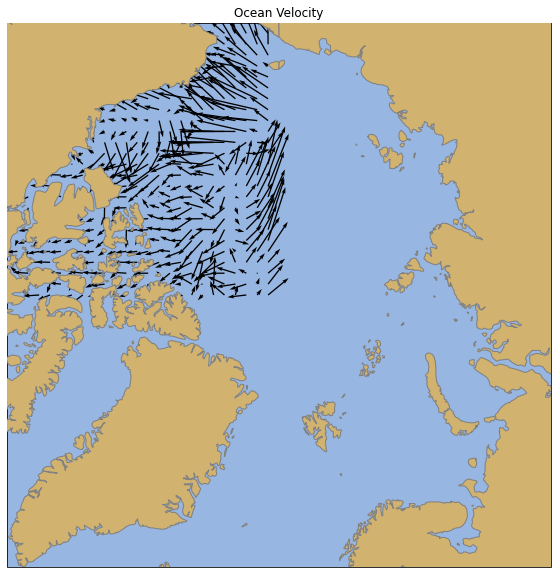

In [125]:
plot(x, y, predicted_v[1,:,:], predicted_u[1,:,:])